# Chapter 9: Markov Chain Monte Carlo

Statistical Rethinking, 2nd Edition

In [1]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm

from scipy import stats

warnings.simplefilter(action="ignore", category=FutureWarning)
pd.set_option("mode.chained_assignment", None)

In [2]:
%config Inline.figure_format = 'retina'
az.style.use("arviz-darkgrid")
az.rcParams["stats.credible_interval"] = 0.89  # sets default credible interval used by arviz

#### Code 9.1

In [3]:
num_weeks = int(1e5)
positions = np.zeros(num_weeks)
current = 10
for i in range(num_weeks):
    # record current position
    positions[i] = current
    # flip coin to generate proposal
    proposal = current + np.random.choice([-1, 1])
    # loop around the archipelago
    if proposal < 1:
        proposal = 10
    if proposal > 10:
        proposal = 1
    # move?
    prob_move = proposal / current
    if np.random.uniform() < prob_move:
        current = proposal

#### Code 9.2 & 9.3

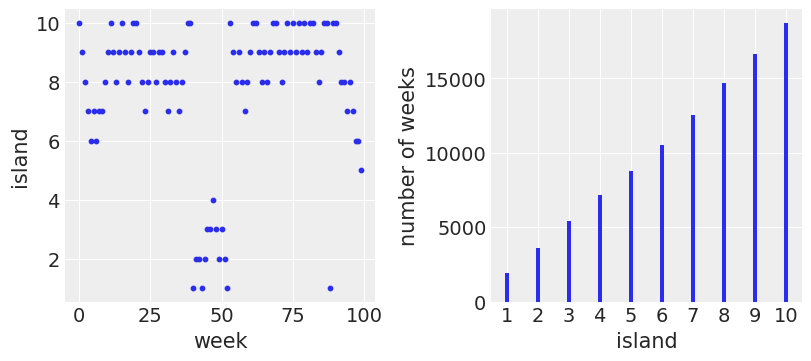

In [4]:
# Figure 9.2
_, axs = plt.subplots(1, 2, figsize=[8, 3.5], constrained_layout=True)

ax0, ax1 = axs

nplot = 100
ax0.scatter(range(nplot), positions[:nplot], s=10)
ax0.set_ylabel("island")
ax0.set_xlabel("week")

counts, _ = np.histogram(positions, bins=10)
ax1.bar(range(10), counts, width=0.1)
ax1.set_ylabel("number of weeks")
ax1.set_xlabel("island")
ax1.set_xticks(range(10))
ax1.set_xticklabels(range(1, 11));

#### Code 9.4

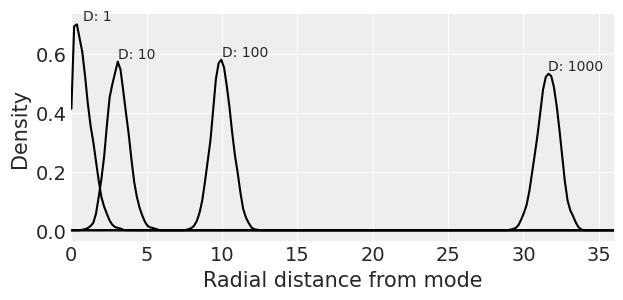

In [5]:
def rad_dist(Y):
    return np.sqrt(np.sum(Y ** 2))


fig, ax = plt.subplots(1, 1, figsize=[7, 3])
xvar = np.linspace(0, 36, 200)

# the book code is wrapped in a loop to reproduce Figure 9.4
for D in [1, 10, 100, 1000]:
    T = int(1e3)
    Y = stats.multivariate_normal(np.zeros(D), np.identity(D)).rvs(T)

    Rd = list(map(rad_dist, Y))

    kde = stats.gaussian_kde(Rd)
    yvar = kde(xvar)
    ax.plot(xvar, yvar, color="k")

    ax.text(np.mean(Rd), np.max(yvar) * 1.02, f"D: {D}")

ax.set_xlim(0, 36)
ax.set_xlabel("Radial distance from mode")
ax.set_ylabel("Density");

#### Code 9.5

In [6]:
def calc_U(x, y, q, a=0, b=1, k=0, d=1):
    muy, mux = q

    U = (
        np.sum(stats.norm.logpdf(y, loc=muy, scale=1))
        + np.sum(stats.norm.logpdf(x, loc=mux, scale=1))
        + stats.norm.logpdf(muy, loc=a, scale=b)
        + stats.norm.logpdf(mux, loc=k, scale=d)
    )

    return -U

#### Code 9.6

In [7]:
# gradient function
# need vector of partial derivatives of U with respect to vector q
def calc_U_gradient(x, y, q, a=0, b=1, k=0, d=1):
    muy, mux = q

    G1 = np.sum(y - muy) + (a - muy) / b ** 2  # dU/dmuy
    G2 = np.sum(x - mux) + (k - mux) / b ** 2  # dU/dmux

    return np.array([-G1, -G2])

#### Code 9.8 - 9.10

9.7 uses the function defined here, so is below

In [8]:
def HMC2(U, grad_U, epsilon, L, current_q, x, y):
    q = current_q
    p = np.random.normal(loc=0, scale=1, size=len(q))  # random flick - p is momentum
    current_p = p
    # Make a half step for momentum at the beginning
    p -= epsilon * grad_U(x, y, q) / 2
    # initialize bookkeeping - saves trajectory
    qtraj = np.full((L + 1, len(q)), np.nan)
    ptraj = qtraj.copy()
    qtraj[0, :] = current_q
    ptraj[0, :] = p

    # Code 9.9 starts here
    # Alternate full steps for position and momentum
    for i in range(L):
        q += epsilon * p  # Full step for the position
        qtraj[i + 1, :] = q
        # Make a full step for the momentum, except at the end of trajectory
        if i != L - 1:
            p -= epsilon * grad_U(x, y, q)
            ptraj[i + 1, :] = p

    # Make a half step for momentum at the end
    p -= epsilon * grad_U(x, y, q) / 2
    ptraj[L, :] = p
    # Negate momentum at end of trajectory to make the proposal symmetric
    p *= -1
    # Evaluate potential and kinetic energies sat start and end of trajectory
    current_U = U(x, y, current_q)
    current_K = np.sum(current_p ** 2) / 2
    proposed_U = U(x, y, q)
    proposed_K = np.sum(p ** 2) / 2
    # Accept or reject the state at end of trajectory, returning either
    # the position at the end of the trajectory or the initial position
    accept = False
    if np.random.uniform() < np.exp(current_U - proposed_U + current_U - proposed_K):
        new_q = q  # accept
        accept = True
    else:
        new_q = current_q  # reject

    return dict(q=new_q, traj=qtraj, ptraj=ptraj, accept=accept)

#### Code 9.7

This code expands upon 9.7 to produce both panels in the top row of Figure 9.6

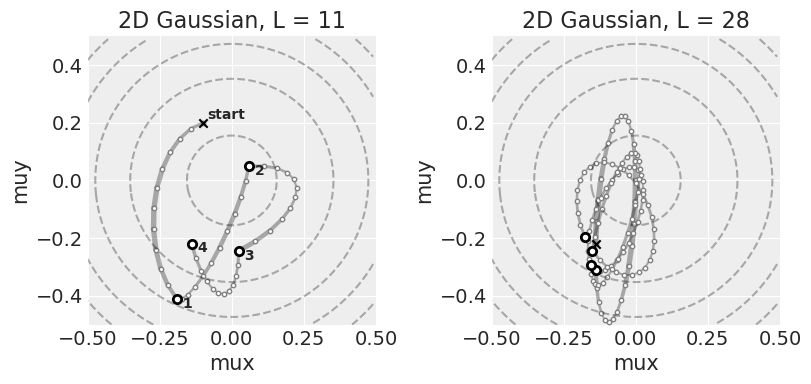

In [9]:
np.random.seed(42)

# test data
real = stats.multivariate_normal([0, 0], np.identity(2))
x, y = real.rvs(50).T

Q = {}
Q["q"] = np.array([-0.1, 0.2])
pr = 0.5
step = 0.03
# L = 11  # 0.03 / 28 for U-turns -- 11 for working example
n_samples = 4

_, axs = plt.subplots(1, 2, figsize=[8, 6], constrained_layout=True)

for L, ax in zip([11, 28], axs):
    ax.scatter(*Q["q"], color="k", marker="x", zorder=3)
    if L == 11:
        ax.text(*Q["q"] + 0.015, "start", weight="bold")
    for i in range(n_samples):
        Q = HMC2(calc_U, calc_U_gradient, step, L, Q["q"], x, y)
        ax.scatter(*Q["q"], color="w", marker="o", edgecolor="k", lw=2, zorder=3)
        if n_samples < 10:
            for j in range(L):
                K0 = np.sum(Q["ptraj"][j, :] ** 2) / 2  # kinetic energy
                ax.plot(
                    Q["traj"][j : j + 2, 0],
                    Q["traj"][j : j + 2, 1],
                    color="k",
                    lw=1 + 1 * K0,
                    alpha=0.3,
                    zorder=1,
                )
            ax.scatter(*Q["traj"].T, facecolor="w", edgecolor="gray", lw=1, zorder=2, s=10)
            if L == 11:
                ax.text(*Q["q"] + [0.02, -0.03], f"{i + 1}", weight="bold")

    ax.set_title(f"2D Gaussian, L = {L}")
    ax.set_xlabel("mux")
    ax.set_ylabel("muy")

    # draw background contours based on real probability defined above
    ax.set_xlim(-pr, pr)
    ax.set_ylim(-pr, pr)
    xs, ys = np.mgrid[-pr:pr:0.01, -pr:pr:0.01]
    p = real.logpdf(np.vstack([xs.flat, ys.flat]).T).reshape(xs.shape)
    ax.contour(xs, ys, p, 4, colors=[(0, 0, 0, 0.3)])
    ax.set_aspect(1);

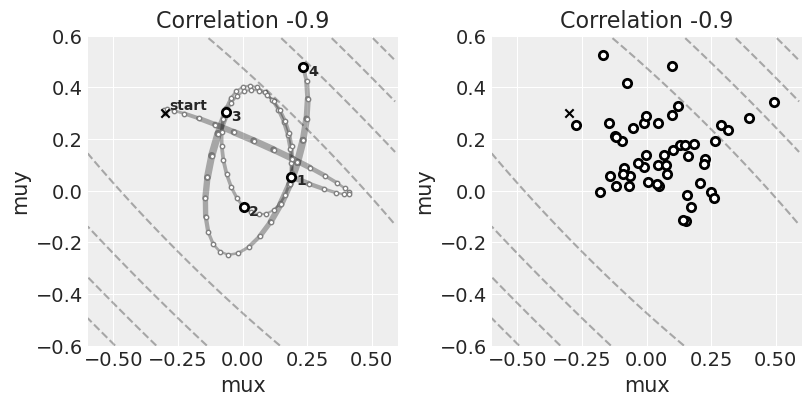

In [10]:
# Figure 9.6 (bottom row) with correlated data

np.random.seed()

# test data
realc = stats.multivariate_normal([0, 0], [[1, -0.9], [-0.9, 1]])  # generate correlated data
x, y = real.rvs(50).T

Q = {}
pr = 0.6
step = 0.03
L = 21  # 28 for U-turns -- 11 for working example

_, axs = plt.subplots(1, 2, figsize=[8, 4], constrained_layout=True)

for n_samples, ax in zip([4, 50], axs):
    Q["q"] = np.array([-0.3, 0.3])

    ax.scatter(*Q["q"], color="k", marker="x", zorder=3)
    if n_samples == 4:
        ax.text(*Q["q"] + 0.015, "start", weight="bold")
    for i in range(n_samples):
        Q = HMC2(calc_U, calc_U_gradient, step, L, Q["q"], x, y)
        ax.scatter(*Q["q"], color="w", marker="o", edgecolor="k", lw=2, zorder=3)
        if n_samples < 10:
            for j in range(L):
                K0 = np.sum(Q["ptraj"][j, :] ** 2) / 2  # kinetic energy
                ax.plot(
                    Q["traj"][j : j + 2, 0],
                    Q["traj"][j : j + 2, 1],
                    color="k",
                    lw=1 + 1 * K0,
                    alpha=0.3,
                    zorder=1,
                )
            if Q["accept"]:
                c = "w"
            else:
                c = "k"
            ax.scatter(*Q["traj"].T, facecolor=c, edgecolor="gray", lw=1, zorder=2, s=10)
            if n_samples == 4:
                ax.text(*Q["q"] + [0.02, -0.03], f"{i + 1}", weight="bold")

    ax.set_title(f"Correlation -0.9")
    ax.set_xlabel("mux")
    ax.set_ylabel("muy")

    # draw background contours based on real probability defined above
    ax.set_xlim(-pr, pr)
    ax.set_ylim(-pr, pr)
    xs, ys = np.mgrid[-pr:pr:0.01, -pr:pr:0.01]
    p = realc.logpdf(np.vstack([xs.flat, ys.flat]).T).reshape(xs.shape)
    ax.contour(xs, ys, p, 5, colors=[(0, 0, 0, 0.3)])
    ax.set_aspect(1);

The correlated case doens't work as well as the uncorrelated case, compared to the book. We're not reproducing the sinusoid trajectories that are shown in the book, so it's possible that there was some underlying change in the likelihood functions?The book doesn't provide code or parameters used to recreate these plots, so we're guessing blind here.

#### Code 9.11

In [11]:
d = pd.read_csv("Data/rugged.csv", delimiter=";")

d["log_gdp"] = np.log(d["rgdppc_2000"])

dd = d.dropna(subset=["log_gdp"])
dd["log_gdp_std"] = dd["log_gdp"] / dd["log_gdp"].mean()
dd["rugged_std"] = dd["rugged"] / dd["rugged"].max()

#### Code 9.12-9.18

By using PyMC3 we are already doing everything in these code blocks (No-Uturn sampling, parallell processing).

To translate the results of `summary` to `rethinking`'s `precis`:

 - `n_eff = ess_mean`
 - `Rhat4 = r_hat`

In [12]:
cid = pd.Categorical(dd["cont_africa"])

with pm.Model() as m_8_3:
    a = pm.Normal("a", 1, 0.2, shape=cid.categories.size)
    b = pm.Normal("b", 0, 0.3, shape=cid.categories.size)

    mu = a[cid] + b[cid] * (dd["rugged_std"] - 0.215)
    sigma = pm.Exponential("sigma", 1)

    log_gdp_std = pm.Normal("log_gdp_std", mu, sigma, observed=dd["log_gdp_std"])

    m_8_3_trace = pm.sample()

az.summary(m_8_3_trace, kind="all", round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:02<00:00, 987.15draws/s] 


,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],1.05,0.01,1.03,1.07,0.0,0.0,1195.00,1195.00,1206.06,784.66,1.00
a[1],0.89,0.02,0.86,0.91,0.0,0.0,1412.71,1406.32,1432.15,660.96,1.00
b[0],-0.14,0.06,-0.24,-0.06,0.0,0.0,953.50,837.44,956.33,693.04,1.00
b[1],0.13,0.07,0.01,0.25,0.0,0.0,1273.36,1160.75,1286.18,795.30,1.01
sigma,0.11,0.01,0.10,0.12,0.0,0.0,1145.37,1145.37,1136.82,770.57,1.01


#### Code 9.19

**Note:** kde plots on the diagonal will be supported in the next release of arviz by setting `marginals=True`

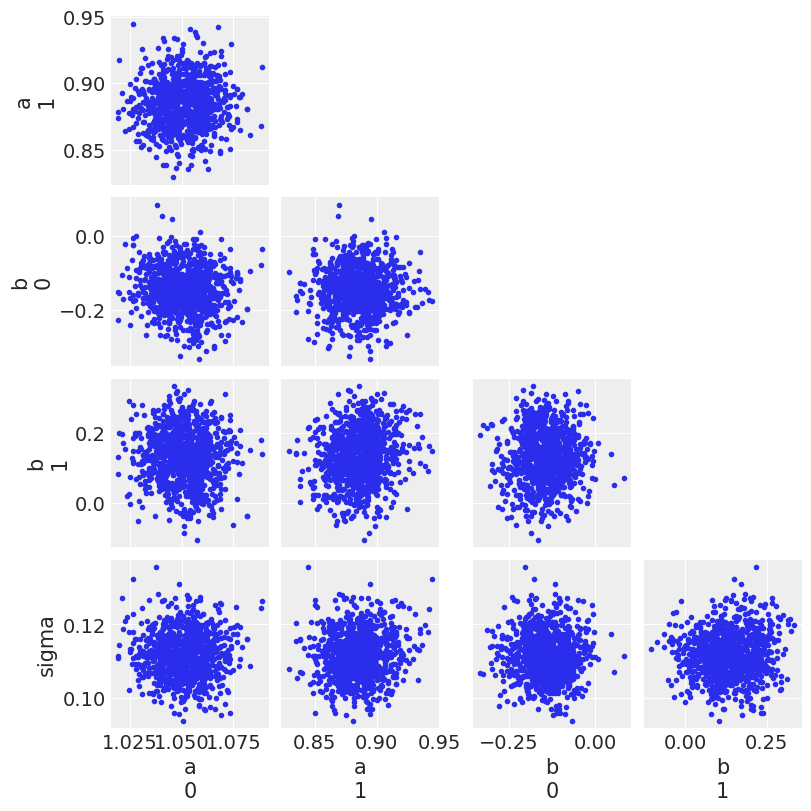

In [13]:
az.plot_pair(m_8_3_trace, figsize=[8, 8]);

#### Code 9.20

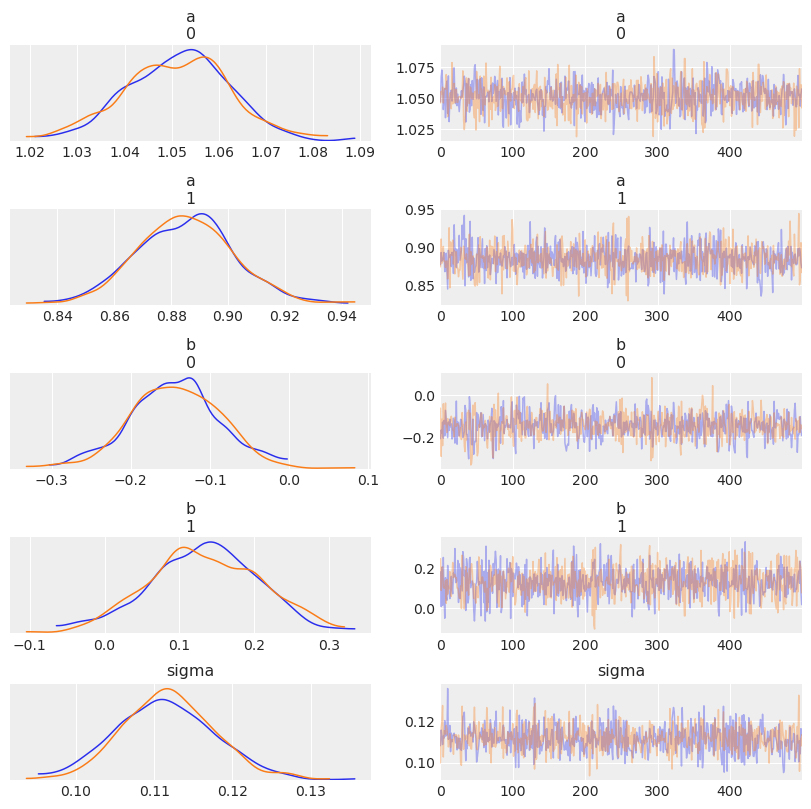

In [14]:
az.plot_trace(m_8_3_trace, figsize=[8, 8]);

#### Code 9.21

This will be possible in the next version of `arviz` using the `kind` argument of `plot_trace`

#### Code 9.22

In [15]:
y = np.array([-1, 1])

with pm.Model() as m_9_2:
    alpha = pm.Normal("alpha", 0, 1000)

    mu = alpha
    sigma = pm.Exponential("sigma", 0.0001)

    yp = pm.Normal("y", mu, sigma, observed=y)

    m_9_2_trace = pm.sample(chains=3)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 2 jobs)
NUTS: [sigma, alpha]
Sampling 3 chains, 364 divergences: 100%|██████████| 3000/3000 [00:03<00:00, 876.94draws/s] 
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 246 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.27066660984168006, but should be close to 0.8. Try to increase the number of tuning steps.
There were 88 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.674114295002773, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


#### Code 9.23

In [16]:
az.summary(m_9_2_trace, round_to=2)

,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,-4.17,323.70,-385.96,457.82,18.18,15.95,317.06,206.63,298.86,228.84,1.07
sigma,498.31,1186.21,11.85,1095.81,95.92,67.95,152.94,152.94,27.76,40.10,1.08


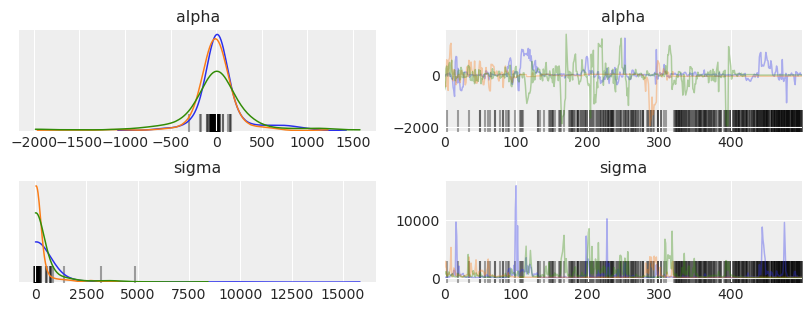

In [17]:
# Figure 9.9 (top)
az.plot_trace(m_9_2_trace, figsize=[8, 3]);

#### Code 9.24

In [18]:
with pm.Model() as m_9_3:
    alpha = pm.Normal("alpha", 1, 10)

    mu = alpha
    sigma = pm.Exponential("sigma", 1)

    yp = pm.Normal("y", mu, sigma, observed=y)

    m_9_3_trace = pm.sample(chains=3)

az.summary(m_9_3_trace, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 2 jobs)
NUTS: [sigma, alpha]
Sampling 3 chains, 2 divergences: 100%|██████████| 3000/3000 [00:02<00:00, 1063.49draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,0.03,1.20,-2.01,1.73,0.05,0.04,498.57,401.86,531.41,435.25,1.00
sigma,1.58,0.82,0.51,2.67,0.04,0.03,397.28,397.28,363.20,372.57,1.01


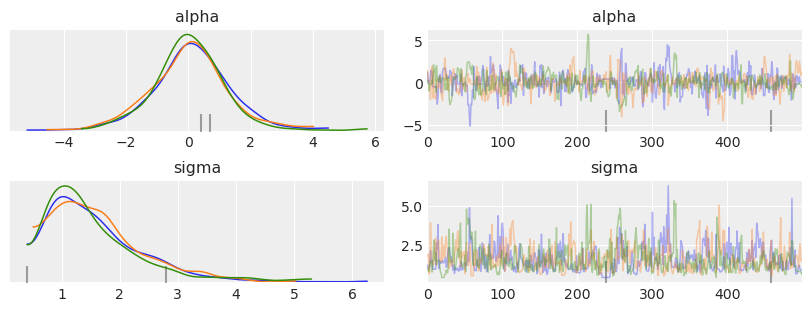

In [19]:
# Figure 9.9 (bottom)
az.plot_trace(m_9_3_trace, figsize=[8, 3]);

100%|██████████| 10000/10000 [00:00<00:00, 20534.63it/s]


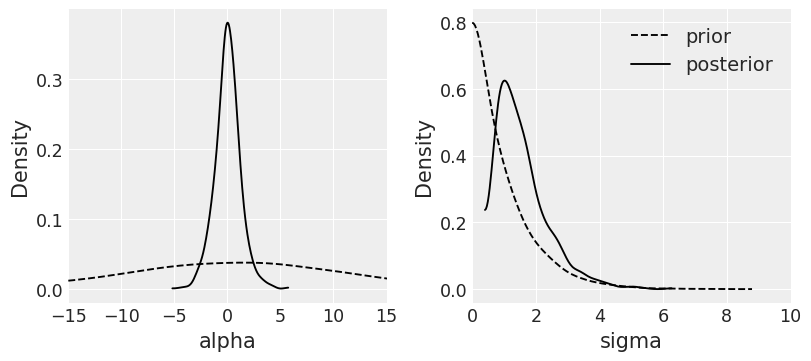

In [20]:
# Figure 9.10
with m_9_3:
    m_9_3_prior = pm.sample_prior_predictive(int(1e4), vars=["alpha", "sigma"])
    m_9_3_post = pm.sample_posterior_predictive(m_9_3_trace, int(1e4), vars=[alpha, sigma])

_, axs = plt.subplots(1, 2, figsize=[8, 3.5], constrained_layout=True)
ax0, ax1 = axs

az.plot_kde(m_9_3_prior["alpha"], ax=ax0, plot_kwargs={"color": "k", "ls": "dashed"})
az.plot_kde(m_9_3_post["alpha"], ax=ax0, plot_kwargs={"color": "k"})
ax0.set_xlim(-15, 15)
ax0.set_xlabel("alpha")

az.plot_kde(
    m_9_3_prior["sigma"],
    ax=ax1,
    plot_kwargs={"color": "k", "ls": "dashed"},
    label="prior",
)
az.plot_kde(m_9_3_post["sigma"], ax=ax1, plot_kwargs={"color": "k"}, label="posterior")
ax1.legend()
ax1.set_xlim(0, 10)
ax1.set_xlabel("sigma")

for ax in axs:
    ax.set_ylabel("Density");

#### Code 9.25

In [21]:
y = np.random.normal(loc=0, scale=1, size=100)

#### Code 9.26

In [22]:
with pm.Model() as m_9_4:
    a1 = pm.Normal("a1", 0, 1000)
    a2 = pm.Normal("a2", 0, 1000)

    mu = a1 + a2
    sigma = pm.Exponential("sigma", 1)

    yp = pm.Normal("y", mu, sigma, observed=y)

    m_9_4_trace = pm.sample(chains=3)

az.summary(m_9_4_trace, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 2 jobs)
NUTS: [sigma, a2, a1]
Sampling 3 chains, 151 divergences: 100%|██████████| 3000/3000 [01:49<00:00, 27.28draws/s]
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5773618101619568, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 83 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4862338569996056, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 45 divergences after tuning. Increase `target_accept` or reparameteri

,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a1,-150.92,636.95,-985.33,568.33,336.71,260.75,3.58,3.58,3.83,12.51,2.24
a2,150.95,636.95,-568.33,985.50,336.71,260.75,3.58,3.58,3.83,13.13,2.24
sigma,0.94,0.10,0.83,1.06,0.05,0.04,3.58,3.58,3.89,23.94,2.20


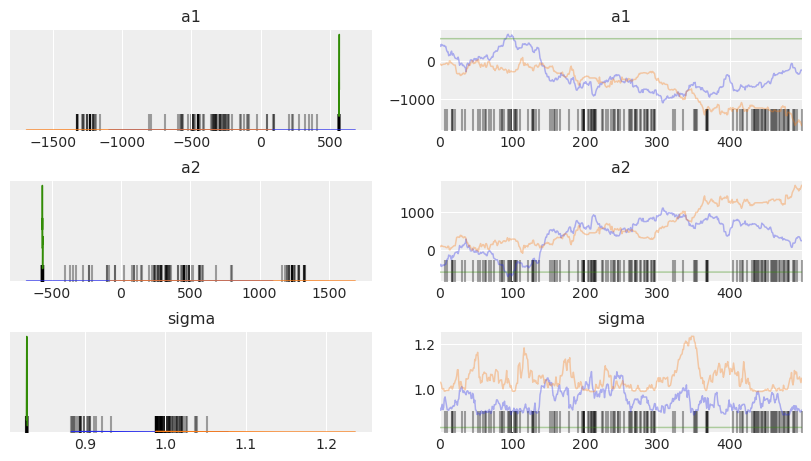

In [23]:
# Figure 9.11 (top half)
az.plot_trace(m_9_4_trace, figsize=[8, 4.5]);

#### Code 9.27

In [24]:
with pm.Model() as m_9_5:
    a1 = pm.Normal("a1", 0, 10)
    a2 = pm.Normal("a2", 0, 10)

    mu = a1 + a2
    sigma = pm.Exponential("sigma", 1)

    yp = pm.Normal("y", mu, sigma, observed=y)

    m_9_5_trace = pm.sample(chains=3)

az.summary(m_9_5_trace, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 2 jobs)
NUTS: [sigma, a2, a1]
Sampling 3 chains, 0 divergences: 100%|██████████| 3000/3000 [00:40<00:00, 74.29draws/s] 


,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a1,-0.23,7.14,-12.14,10.59,0.33,0.28,478.45,319.97,476.90,379.58,1.01
a2,0.27,7.14,-10.55,12.27,0.33,0.28,480.03,319.06,480.96,379.58,1.01
sigma,0.96,0.07,0.85,1.06,0.00,0.00,774.38,773.89,767.67,647.93,1.00


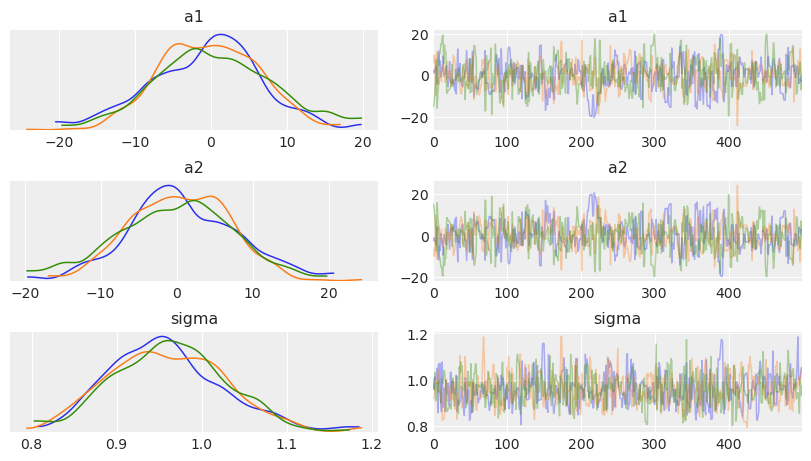

In [25]:
# Figure 9.11 (bottom half)
az.plot_trace(m_9_5_trace, figsize=[8, 4.5]);

In [26]:
%load_ext watermark
%watermark -v -iv -w

pymc3  3.8
numpy  1.18.1
arviz  0.7.0
pandas 1.0.3
CPython 3.7.6
IPython 7.14.0
watermark 2.0.2
